In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sympy as sp


ModuleNotFoundError: No module named 'scipy'

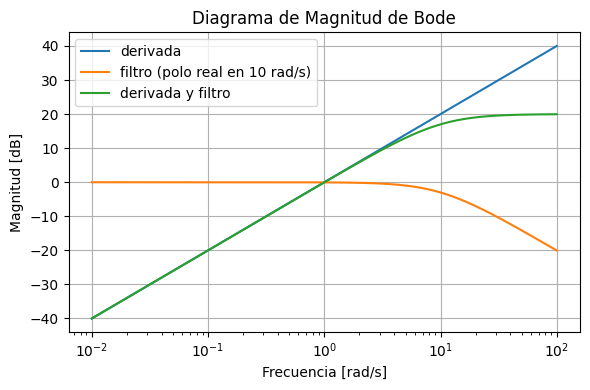

In [ ]:


# Parámetros del sistema
Omega_f = 10.0  # Constante de tiempo

# Función de transferencia
numerator = [Omega_f, 0]  # Coeficientes del numerador (Omega_f s)
denominator = [1, Omega_f]  # Coeficientes del denominador (s + Omega_f)

# Crear el sistema
system = signal.TransferFunction(numerator, denominator)
system_der = signal.TransferFunction([1, 0], 1)
system_fil = signal.TransferFunction(Omega_f, denominator)


# Rango de frecuencias para el gráfico de Bode
frequencies = np.logspace(-2, 2, 1000)

# Calcular la respuesta en frecuencia
frequencies, magnitude, phase = signal.bode(system, frequencies)
frequencies, magnitude_der, phase_der = signal.bode(system_der, frequencies)
frequencies, magnitude_fil, phase_fil = signal.bode(system_fil, frequencies)

# Graficar el diagrama de Bode
plt.figure(figsize=(6, 4))

plt.subplot(1, 1, 1)
plt.semilogx(frequencies, magnitude_der, label='derivada')
plt.semilogx(frequencies, magnitude_fil, label='filtro (polo real en 10 rad/s)')
plt.semilogx(frequencies, magnitude, label='derivada y filtro')
plt.title('Diagrama de Magnitud de Bode')
plt.xlabel('Frecuencia [rad/s]')
plt.ylabel('Magnitud [dB]')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

TransferFunctionContinuous(
array([0.4]),
array([1. , 0.2]),
dt: None
)


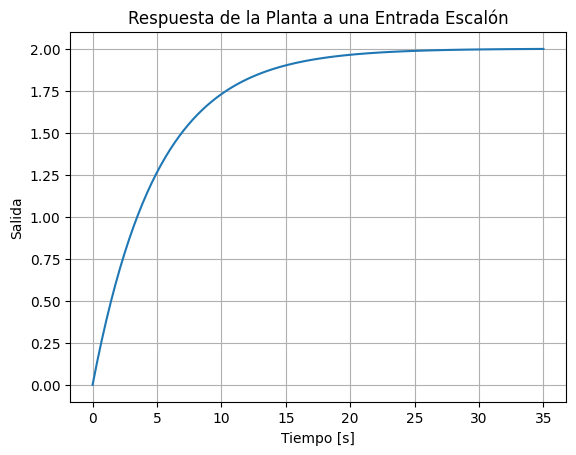

In [ ]:
# prompt: diseño de controlador pid por ubicación de polos para una planta de primer orden

# Parámetros de la planta
K_ = 2.0  # Ganancia estática
tau_ = 5.0  # Constante de tiempo
s_0_ = 1/tau_

# respuesta de la planta
num = K_/tau_
den = [1, s_0_]
system_plant = signal.TransferFunction(num, den)
print(system_plant)

# Simulación de la planta de primer orden a lazo abierto
t, y = signal.step(system_plant)  # Respuesta de la planta

# Graficar la respuesta de la planta
plt.figure()
plt.plot(t, y)
plt.title('Respuesta de la Planta a una Entrada Escalón')
plt.xlabel('Tiempo [s]')
plt.ylabel('Salida')
plt.grid(True)
plt.show()


In [ ]:
s = sp.Symbol('s')
K = sp.Symbol('K')
s_0 = sp.Symbol('s_0')
k_p = sp.Symbol('k_p')
k_i = sp.Symbol('k_i')
k_d = sp.Symbol('k_d')

P = K/(s + s_0)
C = k_p + k_i/s + k_d*s

characteristic_polynomial = sp.simplify(1 +  P*C )
print(sp.latex(characteristic_polynomial))

# Simplify characteristic polynomial = 0
characteristic_polynomial = characteristic_polynomial.as_numer_denom()[0]
print(sp.latex(characteristic_polynomial))

characteristic_polynomial = sp.poly(characteristic_polynomial, s)
print(sp.latex(characteristic_polynomial))


\frac{K \left(k_{i} + s \left(k_{d} s + k_{p}\right)\right) + s \left(s + s_{0}\right)}{s \left(s + s_{0}\right)}
K \left(k_{i} + s \left(k_{d} s + k_{p}\right)\right) + s \left(s + s_{0}\right)
\operatorname{Poly}{\left( \left(K k_{d} + 1\right) s^{2} + \left(K k_{p} + s_{0}\right) s + K k_{i}, s, domain=\mathbb{Z}\left[k_{d}, k_{p}, k_{i}, K, s_{0}\right] \right)}


In [ ]:
# Desired polynomial
pol_des = sp.Poly(s**2 + 2*s + 4, s)

# Equations
eqs = [sp.Eq(pol_des.all_coeffs()[i], characteristic_polynomial.all_coeffs()[i]) for i in range(3)]
print(eqs)
sol_PID = sp.solve(eqs, (k_p, k_i, k_d))
print(sol_PID)

C_tuned = C.subs(sol_PID)
print(C_tuned)

[Eq(1, K*k_d + 1), Eq(2, K*k_p + s_0), Eq(4, K*k_i)]
{k_d: 0, k_i: 4/K, k_p: (2 - s_0)/K}
(2 - s_0)/K + 4/(K*s)


In [ ]:
# Actual plant
P_ = P.subs({s_0: s_0_, K: K_})
print(P_)

2.0/(s + 0.2)


In [ ]:
# Actual controller
C_ = C_tuned.subs({K: K_, s_0: s_0_})
print(C_)

0.9 + 2.0/s


In [ ]:
# recostruct closed loop
H = P*C/(1+P*C)
print(sp.latex(H))
H_ = P_*C_ / (1 + P_*C_)
print(sp.latex(H_))
H_

\frac{K \left(k_{d} s + \frac{k_{i}}{s} + k_{p}\right)}{\left(s + s_{0}\right) \left(\frac{K \left(k_{d} s + \frac{k_{i}}{s} + k_{p}\right)}{s + s_{0}} + 1\right)}
\frac{2.0 \cdot \left(0.9 + \frac{2.0}{s}\right)}{\left(s + 0.2\right) \left(\frac{2.0 \cdot \left(0.9 + \frac{2.0}{s}\right)}{s + 0.2} + 1\right)}


2.0*(0.9 + 2.0/s)/((s + 0.2)*(2.0*(0.9 + 2.0/s)/(s + 0.2) + 1))

In [ ]:
# Rational function
H_tf = sp.apart(H_)
print(sp.latex(H_tf))
H_tf

\frac{1.0 \cdot \left(0.45 s + 1.0\right)}{0.25 s^{2} + 0.5 s + 1.0}


1.0*(0.45*s + 1.0)/(0.25*s**2 + 0.5*s + 1.0)

In [ ]:
# Closed loop transfer function
num_closed_loop = np.array(sp.Poly(H_tf.as_numer_denom()[0], s).all_coeffs(), dtype=float)
den_closed_loop = np.array(sp.Poly(H_tf.as_numer_denom()[1], s).all_coeffs(), dtype=float)

closed_loop = signal.TransferFunction(num_closed_loop, den_closed_loop)
print(closed_loop)

TransferFunctionContinuous(
array([1.8, 4. ]),
array([1., 2., 4.]),
dt: None
)


In [ ]:
# ideal transfer function
H_tf_ideal = 4/pol_des
num_closed_loop_ideal = np.array(sp.Poly(H_tf_ideal.as_numer_denom()[0], s).all_coeffs(), dtype=float)
den_closed_loop_ideal = np.array(sp.Poly(H_tf_ideal.as_numer_denom()[1], s).all_coeffs(), dtype=float)
closed_loop_ideal = signal.TransferFunction(num_closed_loop_ideal, den_closed_loop_ideal)
closed_loop_ideal


TransferFunctionContinuous(
array([4.]),
array([1., 2., 4.]),
dt: None
)

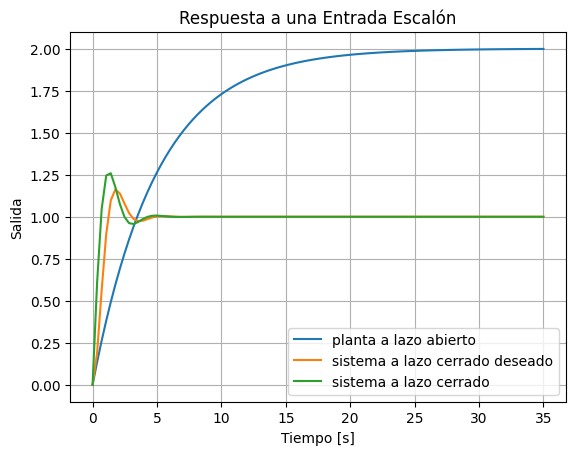

In [ ]:
# Simulate response
t_cl, y_cl = signal.step(closed_loop, T=t)
t_cl, y_cl_ideal = signal.step(closed_loop_ideal, T=t)

plt.figure()
plt.plot(t, y, label='planta a lazo abierto')
plt.plot(t_cl, y_cl_ideal, label='sistema a lazo cerrado deseado')
plt.plot(t_cl, y_cl, label='sistema a lazo cerrado')
plt.title('Respuesta a una Entrada Escalón')
plt.xlabel('Tiempo [s]')
plt.ylabel('Salida')
plt.legend()
plt.grid(True)
plt.show()
